In [15]:
import numpy as np
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage import io, morphology
from skimage.morphology import skeletonize
from skimage.transform import resize
from scipy.ndimage import distance_transform_edt

In [45]:
# Cargar la imagen binaria de 'horse'
# Devuelve un array 2D booleano
# horse == True en el "caballo", y False en el fondo
horse = data.horse()
horse =  np.logical_not(horse)
horse

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(328, 400))

In [46]:
skeleton = skeletonize(horse)

In [47]:
# Transformada de distancia desde el borde
dist_edge = distance_transform_edt(horse)

In [48]:
# Transformada de distancia desde el esqueleto
# Invertimos el esqueleto para calcular la distancia a los "0"
# (es decir, al esqueleto) dentro de la región True
skeleton_inv = np.logical_not(skeleton)
dist_skel = distance_transform_edt(skeleton_inv)


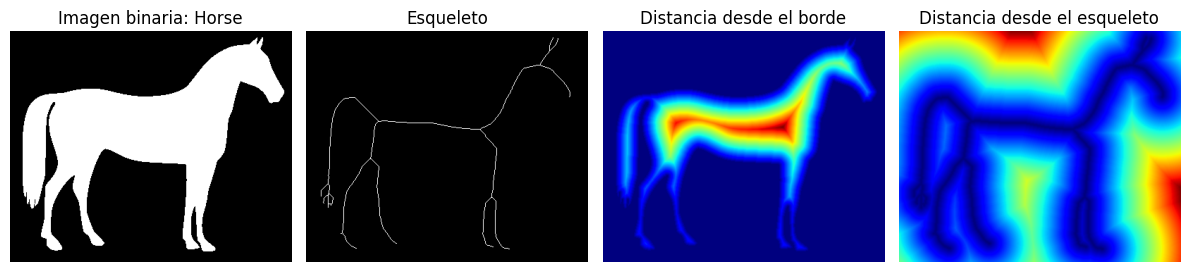

In [49]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(horse, cmap='gray')
axes[0].set_title("Imagen binaria: Horse")
axes[0].axis('off')

axes[1].imshow(skeleton, cmap='gray')
axes[1].set_title("Esqueleto")
axes[1].axis('off')

axes[2].imshow(dist_edge, cmap='jet')
axes[2].set_title("Distancia desde el borde")
axes[2].axis('off')

axes[3].imshow(dist_skel, cmap='jet')
axes[3].set_title("Distancia desde el esqueleto")
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [50]:
from scipy.ndimage import convolve

In [51]:
def find_endpoints(skel):
    """
    Dado un esqueleto binario (bool), retorna una máscara booleana
        con True en los endpoints.
        """
        # Vecindad 3x3 para contar vecinos (excluyendo el píxel central)
    kernel = np.array([[1,1,1],
                       [1,0,1],
                       [1,1,1]], dtype=np.uint8)
     # Contamos vecinos de cada píxe
    neighbours_count = convolve(skel.astype(np.uint8), kernel, mode="constant")

    endpoints = skel & (neighbours_count == 1)
    return endpoints

In [52]:
from skimage import measure

def prune_iteration(skel, min_length = 10):
    """
    Elimina ramas cortas (< min_length) en una sola iteración.
    Retorna (skel_podado, hubo_cambios).
    """
    skel_pruned = skel.copy()
    changed = False

    # 1. Identificar endpoints
    endpoints = find_endpoints(skel)
    endpoint_positions = np.argwhere(endpoints)

    #Etiquetar componentes conecatods del esqueleto
    labels = measure.label(skel, connectivity=2)
    
    #Revisar cada endpoint
    for(ex, ey) in endpoint_positions:
        label = labels[ex,ey]
        if label == 0:
            continue
    
    #3. Tomamos la componente a la que pertenece
    component_mask = (labels == label)

    # Recorremos la rama desde este endpoint.
    # Simplificaremos: calculamos la distancia geodésica dentro
    # de la componente a cada otro endpoint. Si la distancia mínima
    # es < min_length, la borramos.
    # (Para una implementación más exacta, se puede hacer BFS/DFS.  )
    
    # Buscamos si hay otros endpoints en la misma componente.
    other_endpoints = endpoints & component_mask

    # Si solo tiene un endpoint, es un componente muy pequeño
        # o bien un extremo que no se conecta a nada.
        # Si hay >1 endpoint, medimos la distancia al "más cercano".
    n_endpoints_in_component = np.sum(other_endpoints)
    if n_endpoints_in_component <= 1:
        # No hay otra punta a la que conectarse, lo borramos
            # Elimino todos los píxeles de esa componente
        skel_pruned[component_mask] = False
        changed = True
    else:
        pass
    return skel_pruned, changed

In [53]:
def prune_skeleton(skel, min_length = 10, max_iterations = 10):
    pruned = skel.copy()
    for _ in range(max_iterations):
        pruned, changed = prune_iteration(pruned, min_length)
        if not changed:
            break
    return pruned

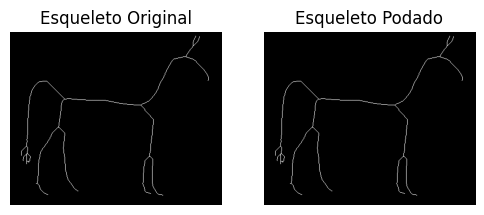

In [54]:
skeleton_pruned = prune_skeleton(skeleton, min_length=20, max_iterations= 10)
# Visualizar el esqueleto podado
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(skeleton, cmap='gray')
plt.title("Esqueleto Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(skeleton_pruned, cmap='gray')
plt.title("Esqueleto Podado")
plt.axis('off')

plt.show()